# All pip install if needed

# TEST_MODE

In [1]:
TEST_MODE=False

# Seeds

In [2]:
import numpy as np
import random
import torch 
import transformers 
import os

seed=398

os.environ['PYTHONHASHSEED']=str(seed)
random.seed(seed)

# Device

In [3]:
device=torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Imports

In [4]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import tqdm 


from torch.utils.data import Dataset, DataLoader
from torchvision.transforms import v2
import PIL
from PIL import Image


import timm, math
from catboost import CatBoostRegressor, Pool

from tqdm import tqdm 

import transformers 
from transformers import Trainer, TrainingArguments, AutoModelForSequenceClassification, AutoTokenizer, CLIPProcessor, CLIPModel


/usr/local/lib/python3.11/dist-packages/pydantic/_internal/_generate_schema.py:2249: UnsupportedFieldAttributeWarning: The 'repr' attribute with value False was provided to the `Field()` function, which has no effect in the context it was used. 'repr' is field-specific metadata, and can only be attached to a model field using `Annotated` metadata or by assignment. This may have happened because an `Annotated` type alias using the `type` statement was used, or if the `Field()` function was attached to a single member of a union type.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/pydantic/_internal/_generate_schema.py:2249: UnsupportedFieldAttributeWarning: The 'frozen' attribute with value True was provided to the `Field()` function, which has no effect in the context it was used. 'frozen' is field-specific metadata, and can only be attached to a model field using `Annotated` metadata or by assignment. This may have happened because an `Annotated` type alias using the `type` 

AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

# Loading data

In [5]:
train=pd.read_parquet('/kaggle/input/auto-trying/train_dataset (2).parquet')
test=pd.read_parquet('/kaggle/input/auto-trying/test_dataset (2).parquet')
sample=pd.read_csv('/kaggle/input/auto-trying/sample_submission (18).csv')

train_img_dir='/kaggle/input/auto-trying/autoprice/АвтоПрайс/train_images'
test_img_dir='/kaggle/input/auto-trying/autoprice/АвтоПрайс/test_images'


In [6]:
TARGET = 'price_TARGET'

In [7]:
num_feats=train.select_dtypes(include='number').columns.tolist()
cat_feats=train.select_dtypes(include='object').columns.tolist()

## IF TEST_MODE

In [8]:
if TEST_MODE:
    train=train[:1000]

## Train and eval split

In [9]:
bins = pd.qcut(train[TARGET], q=20, duplicates='drop', labels=False)

In [10]:
train_data, eval_data=train_test_split(train, test_size=0.15, stratify=bins, random_state=seed)

# EDA

In [11]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 70000 entries, 0 to 69999
Data columns (total 35 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   ID                            70000 non-null  int64  
 1   equipment                     55572 non-null  object 
 2   body_type                     70000 non-null  object 
 3   drive_type                    70000 non-null  object 
 4   engine_type                   70000 non-null  object 
 5   doors_number                  70000 non-null  int64  
 6   color                         70000 non-null  object 
 7   pts                           65026 non-null  object 
 8   audiosistema                  25824 non-null  object 
 9   diski                         32190 non-null  object 
 10  electropodemniki              36271 non-null  object 
 11  fary                          22652 non-null  object 
 12  salon                         34500 non-null  object 
 13  u

In [12]:
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 25000 entries, 0 to 24999
Data columns (total 34 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   ID                            25000 non-null  int64  
 1   equipment                     19468 non-null  object 
 2   body_type                     25000 non-null  object 
 3   drive_type                    25000 non-null  object 
 4   engine_type                   25000 non-null  object 
 5   doors_number                  25000 non-null  int64  
 6   color                         25000 non-null  object 
 7   pts                           23047 non-null  object 
 8   audiosistema                  8805 non-null   object 
 9   diski                         13177 non-null  object 
 10  electropodemniki              9301 non-null   object 
 11  fary                          9057 non-null   object 
 12  salon                         12968 non-null  object 
 13  u

## for classification

## for regression

In [13]:
ID_COL = "ID"

# Feature Engineering

In [14]:
# === FEATURE LISTS ===
useless_cols = []  # пока ничего не выкидываем

# (опционально) разбери дату, если нужна простая фича
if 'close_date' in train.columns:
    for df in (train_data, eval_data, test):
        df['close_date'] = pd.to_datetime(df['close_date'], errors='coerce')
        df['close_year'] = df['close_date'].dt.year
        df['close_mon']  = df['close_date'].dt.month
        df['close_dow']  = df['close_date'].dt.dayofweek
        df.drop(columns=['close_date'], inplace=True)

# применим useless_cols (если вдруг что-то добавишь)
if useless_cols:
    train_data = train_data.drop(columns=[c for c in useless_cols if c in train_data.columns])
    eval_data  = eval_data.drop(columns=[c for c in useless_cols if c in eval_data.columns])
    test       = test.drop(columns=[c for c in useless_cols if c in test.columns])

# Разделим на числовые/категориальные под CatBoost
def _split_num_cat(df):
    num_cols = [c for c in df.columns if (df[c].dtype != 'object' and c not in [TARGET, 'ID'])]
    cat_cols = [c for c in df.columns if (df[c].dtype == 'object')]
    return num_cols, cat_cols

num_feats_train, cat_feats_train = _split_num_cat(train_data)


In [15]:
from datetime import datetime

# мульти-колонки из условия (списки)
MULTI_COLS = [
    "aktivnaya_bezopasnost_mult", "audiosistema_mult", "shini_i_diski_mult",
    "electroprivod_mult", "fary_mult", "multimedia_navigacia_mult", "obogrev_mult",
    "pamyat_nastroek_mult", "podushki_bezopasnosti_mult", "pomosh_pri_vozhdenii_mult",
    "protivoygonnaya_sistema_mult", "salon_mult", "upravlenie_klimatom_mult"
]

# одиночные категориальные опции (строка с одним значением)
SINGLE_OPT_COLS = [
    "audiosistema", "diski", "electropodemniki", "fary",
    "salon", "upravlenie_klimatom", "usilitel_rul"
]

# основные базовые признаки из условия
BASE_KEEP = [
    "body_type","drive_type","engine_type","doors_number","color","pts",
    "steering_wheel","crashes_count","owners_count","mileage",
    "latitude","longitude","close_date","equipment"
] + SINGLE_OPT_COLS + MULTI_COLS

import numpy as np
import ast

def _safe_list(x):
    """
    Приводит значение из колонок *_mult к списку строк.
    Поддерживает: NaN/None, list/tuple/set, numpy.ndarray, строки вида "['A','B']" / "[None]" / "None",
    одиночные строки.
    """
    # 1) пустые значения
    if x is None:
        return []
    # 2) уже list/tuple/set
    if isinstance(x, (list, tuple, set)):
        out = []
        for v in x:
            if isinstance(v, float) and np.isnan(v):
                continue
            sv = str(v)
            if sv.lower() == "none":
                continue
            out.append(sv)
        return out
    # 3) numpy массив
    if isinstance(x, np.ndarray):
        out = []
        for v in x.tolist():
            if isinstance(v, float) and np.isnan(v):
                continue
            sv = str(v)
            if sv.lower() == "none":
                continue
            out.append(sv)
        return out

    # 4) строка/скаляр
    s = str(x).strip()
    if s == "" or s.lower() in {"none", "[none]"}:
        return []
    # попытаться распарсить строковое представление списка
    if (s.startswith("[") and s.endswith("]")) or (s.startswith("(") and s.endswith(")")):
        try:
            val = ast.literal_eval(s)
            if val is None:
                return []
            if isinstance(val, (list, tuple, set)):
                return [str(v) for v in val if str(v).lower() != "none"]
            return [str(val)]
        except Exception:
            # не смогли распарсить — трактуем как одно значение
            return [s]
    # обычный одиночный токен
    return [s]


def featurize(df: pd.DataFrame) -> pd.DataFrame:
    df = df.copy()

    # оставим только известные колонки (если чего-то нет — просто пропустится)
    cols = [c for c in BASE_KEEP if c in df.columns] + [ID_COL] + ([TARGET] if TARGET in df.columns else [])
    df = df[[c for c in cols if c in df.columns]]

    # даты
    if "close_date" in df.columns:
        # ожидаем yyyy-mm-dd или iso; парсим в фичи
        dt = pd.to_datetime(df["close_date"], errors="coerce")
        df["close_year"] = dt.dt.year
        df["close_month"] = dt.dt.month
        df["close_dow"] = dt.dt.dayofweek
        df.drop(columns=["close_date"], inplace=True)

    # equipment — возьмём длину текста как простую прокси-фичу
    if "equipment" in df.columns:
        df["equipment_len"] = df["equipment"].astype(str).str.len()
        df.drop(columns=["equipment"], inplace=True)

    # мульти-списки -> «сколько опций»
    for c in MULTI_COLS:
        if c in df.columns:
        # не вызываем .apply дважды; считаем длину сразу
            def _len_safe(x):
                try:
                    return len(_safe_list(x))
                except Exception:
                    return 0
            df[c + "_cnt"] = df[c].apply(_len_safe).astype("int16")
            df.drop(columns=[c], inplace=True)

    # простые пропуски
    for c in ["crashes_count","owners_count","mileage","latitude","longitude","doors_number"]:
        if c in df.columns:
            df[c] = pd.to_numeric(df[c], errors="coerce")

    # категории — переведём в string (CatBoost сам съест)
    cat_cols = []
    for c in df.columns:
        if c in ["body_type","drive_type","engine_type","color","pts","steering_wheel"] + SINGLE_OPT_COLS:
            if c in df.columns:
                df[c] = df[c].astype("string")
                cat_cols.append(c)

    # заполним пропуски в числах
    for c in df.select_dtypes(include=[np.number]).columns:
        df[c] = df[c].fillna(df[c].median())

    # вернём список категор. колонок, пригодится для CatBoost
    df.attrs["cat_cols"] = cat_cols
    return df

# применяем
train_data = featurize(train_data)
eval_data = featurize(eval_data)
test  = featurize(test)

cat_cols = train_data.attrs.get("cat_cols", [])


# Catboost over only table data

In [16]:
train_data=train_data.drop(columns=useless_cols)
eval_data=eval_data.drop(columns=useless_cols)
test=test.drop(columns=useless_cols)

In [17]:
X_train = train_data.drop(columns=[TARGET, 'ID'])
y_train = train_data[TARGET]

X_eval  = eval_data.drop(columns=[TARGET, 'ID'])
y_eval  = eval_data[TARGET]

In [18]:
import pandas as pd
import numpy as np

# 1) Возьмём только те категориальные, что реально есть в матрице признаков
cat_cols_in_X = [c for c in cat_cols if c in X_train.columns]

# 2) Заполним пропуски в категориальных "<NA>" и приведём к строкам
for df_ in (X_train, X_eval):
    for c in cat_cols_in_X:
        # строго строковый тип без pandas.NA
        df_[c] = df_[c].astype("string").fillna("<NA>").astype(object)

# 3) На всякий случай убедимся, что числовых NaN нет
for df_ in (X_train, X_eval):
    num_cols = df_.select_dtypes(include=[np.number]).columns
    for c in num_cols:
        if df_[c].isna().any():
            df_[c] = df_[c].fillna(df_[c].median())

# 4) sanity-check перед обучением
print("Any NaN left in X_train? ->", X_train.isna().any().any())
print("Any NaN left in X_eval?  ->", X_eval.isna().any().any())

# 5) учим CatBoost
catboost_model = CatBoostRegressor(
    iterations=3000,
    learning_rate=0.03,
    depth=8,
    loss_function='RMSE',
    eval_metric='MAPE',  # при желании можешь добавить 'MAPE' в custom_metric
    l2_leaf_reg=2,
    verbose=100,
    task_type='GPU',
)

catboost_model.fit(
    X_train, y_train,
    eval_set=(X_eval, y_eval),
    cat_features=cat_cols_in_X,      # <= передаём только валидные категориальные
    early_stopping_rounds=600
)


Any NaN left in X_train? -> False
Any NaN left in X_eval?  -> False
0:	learn: 1.9162333	test: 1.9090022	best: 1.9090022 (0)	total: 5.5s	remaining: 4h 34m 57s
100:	learn: 0.8614097	test: 0.8655186	best: 0.8655186 (100)	total: 8.73s	remaining: 4m 10s
200:	learn: 0.7155351	test: 0.7265594	best: 0.7265594 (200)	total: 11.9s	remaining: 2m 45s
300:	learn: 0.6782054	test: 0.6933430	best: 0.6933211 (299)	total: 15.1s	remaining: 2m 15s
400:	learn: 0.6598814	test: 0.6761050	best: 0.6761050 (400)	total: 18.3s	remaining: 1m 58s
500:	learn: 0.6498969	test: 0.6690286	best: 0.6687000 (497)	total: 21.6s	remaining: 1m 47s
600:	learn: 0.6399355	test: 0.6622148	best: 0.6622148 (600)	total: 24.9s	remaining: 1m 39s
700:	learn: 0.6322706	test: 0.6576589	best: 0.6576003 (699)	total: 28.2s	remaining: 1m 32s
800:	learn: 0.6253944	test: 0.6530077	best: 0.6530077 (800)	total: 31.4s	remaining: 1m 26s
900:	learn: 0.6193787	test: 0.6499774	best: 0.6499769 (892)	total: 34.7s	remaining: 1m 20s
1000:	learn: 0.6137265	

# Datasets

In [19]:
import glob

class OverallDataset(Dataset):
    def __init__(self, df, img_dir, transforms, is_train):
        self.df = df.reset_index(drop=True)
        self.img_dir = img_dir
        self.transforms = transforms
        self.is_train = is_train
        
    def __len__(self):
        return len(self.df)

    def _pick_first_image(self, item_id):
        # 1) ожидаем <ID>_0.jpg
        p0 = os.path.join(self.img_dir, f'{item_id}_0.jpg')
        if os.path.exists(p0):
            return p0
        # 2) иначе любой <ID>_*.jpg c минимальным суффиксом
        cand = sorted(glob.glob(os.path.join(self.img_dir, f'{item_id}_*.jpg')))
        return cand[0] if cand else None

    def __getitem__(self, idx):
        row = self.df.iloc[idx]
        img_id = row['ID']
        img_file = self._pick_first_image(img_id)

        if img_file is None:
            # запасной вариант: чёрный квадрат, чтобы не падать
            image = Image.new('RGB', (IMG_SIZE, IMG_SIZE), (0, 0, 0))
        else:
            image = Image.open(img_file).convert('RGB')

        if self.transforms is not None:
            image = self.transforms(image)

        if self.is_train:
            label = torch.tensor(row[TARGET], dtype=torch.float32)
            return {'image': image, 'label': label}
        else:
            return {'image': image}

        

## Augmentations

In [20]:
IMG_SIZE=224
train_transforms = v2.Compose([
    #v2.RandomResizedCrop(IMG_SIZE, scale=(0.8, 1.0), ratio=(0.75, 1.33),
     #                    interpolation=InterpolationMode.BILINEAR, antialias=True),
    v2.Resize((IMG_SIZE, IMG_SIZE)),
    v2.RandomHorizontalFlip(0.5),
    #v2.RandomApply([v2.Affine(degrees=10, translate=(0.02, 0.02), scale=(0.95, 1.05))], p=0.25),
    v2.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.02),
    #v2.RandomGrayscale(p=0.05),
    v2.ToImage(),
    v2.ToDtype(torch.float32, scale=True),
    v2.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    #v2.RandomErasing(p=0.25, scale=(0.02, 0.10), ratio=(0.3, 3.3))
])
eval_transforms = v2.Compose([
    #v2.Resize(int(IMG_SIZE * 1.14), antialias=True),
    v2.Resize((IMG_SIZE, IMG_SIZE)),
    #v2.CenterCrop(IMG_SIZE),
    v2.ToImage(),
    v2.ToDtype(torch.float32, scale=True),
    v2.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

test_transforms=v2.Compose([
    v2.Resize((IMG_SIZE, IMG_SIZE)),
    v2.ToImage(),
    v2.ToDtype(torch.float32, scale=True),
    v2.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

## Creation of datasets

In [21]:
train_dataset=OverallDataset(train_data, train_img_dir, train_transforms, is_train=True)
eval_dataset=OverallDataset(eval_data, train_img_dir, eval_transforms, is_train=True)


test_dataset=OverallDataset(test, test_img_dir, test_transforms, is_train=False)

# Dataloaders

In [22]:
BATCH_SIZE=32
train_dataloader=DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=4)
eval_dataloader=DataLoader(eval_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=4)
test_dataloader=DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=4)

# Image model and things 

In [23]:
model_name='resnet50' # tf_efficientnet_b3_ns  swin_base_patch4_window7_224

model=timm.create_model(model_name, pretrained=True, num_classes=1).to(device)

model.safetensors:   0%|          | 0.00/102M [00:00<?, ?B/s]

In [24]:
NUM_EPOCHS=1

In [25]:

#0.01 * (effective_batch/256)
accum_steps=1
effective_batch=BATCH_SIZE/accum_steps
base_lr=0.01 * (effective_batch/256) #for cnn
#base_lr=3e-4 * (effective_batch/256)
criterion=torch.nn.SmoothL1Loss(beta=1.0)
optimizer=torch.optim.SGD(model.parameters(), lr=base_lr,)
#SequentialLR
#optimizer = torch.optim.AdamW(
#    model.parameters(),
#    lr=base_lr,          # or 2e-4
    #weight_decay=1e-2
#)
total_steps=NUM_EPOCHS*len(train_dataloader)
warmup_steps=0.05*total_steps
scheduler1=torch.optim.lr_scheduler.LinearLR(optimizer, start_factor=1e-3, end_factor=1.00, total_iters=warmup_steps,)
scheduler2=torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=total_steps - warmup_steps, eta_min=base_lr*0.06)
scheduler=torch.optim.lr_scheduler.SequentialLR(optimizer, schedulers=[scheduler1, scheduler2], milestones=[warmup_steps])
ema_alpha = 0.98

In [26]:
#OOF in order to have good predictions that we can feed into catboost!



In [27]:
for epoch in range(NUM_EPOCHS):
    pbar_train=tqdm(train_dataloader, desc=f'Training {epoch}/{NUM_EPOCHS}: ', leave=True)
    train_se_sum = 0.0
    train_count  = 0
    model.train()
    loss_ema = None
    
    for step, batch in enumerate(pbar_train):
        
        X=batch['image'].to(device)
        y=batch['label'].to(device)
        optimizer.zero_grad()

        logits=model(X).squeeze(-1)
        loss=criterion(logits, y)
        loss.backward()

        train_se_sum += torch.nn.functional.mse_loss(logits, y, reduction='sum').item()
        train_count  += y.numel()
        

        rmse_so_far   = math.sqrt(train_se_sum / max(1, train_count))
        loss_ema      = loss.item() if loss_ema is None else (ema_alpha*loss_ema + (1-ema_alpha)*loss.item())
        lr            = optimizer.param_groups[0]['lr']
        if step % 10 == 0:
            pbar_train.set_postfix({
                "loss": f"{loss_ema:.4f}",
                "rmse": f"{rmse_so_far:.4f}",
                "lr":   f"{lr:.2e}",
            }, refresh=False)

        optimizer.step()
        scheduler.step()
        
    train_rmse = math.sqrt(train_se_sum / max(1, train_count))

    model.eval()
    val_se_sum, val_count = 0.0, 0
    pbar_eval=tqdm(eval_dataloader, desc='Evaluation: ', leave=True)
    with torch.no_grad():
        for step, batch in enumerate(pbar_eval):
            X=batch['image'].to(device)
            y=batch['label'].to(device)

            logits=model(X).squeeze(-1)
            loss=criterion(logits, y)

            val_se_sum += torch.nn.functional.mse_loss(logits, y, reduction='sum').item()
            val_count  += y.numel()

            rmse_so_far = math.sqrt(val_se_sum / max(1, val_count))

            if step % 10 == 0:
                pbar_eval.set_postfix_str(f"rmse={rmse_so_far:.4f}", refresh=False)
                
    val_rmse = math.sqrt(val_se_sum / max(1, val_count))
        
    print(f"Epoch {epoch+1}/{NUM_EPOCHS} | train RMSE: {train_rmse:.5f} | val RMSE: {val_rmse:.5f}")    
        

Evaluation: 100%|██████████| 329/329 [00:40<00:00,  8.15it/s, rmse=1155908.9012]

Epoch 1/1 | train RMSE: 1168474.25381 | val RMSE: 1152704.11534


# ДОБАВИТЬ ПРЕДИКТЫ(ИЛИ ЛОГИТЫ) КАК ФИЧА В КАТБУСТ !!!!!!!!!!!!!!!!!!!!!!!!!!!!!

In [28]:
@torch.no_grad()
def infer_logits_and_preds(model, loader, task="regression", num_classes=1, device="cuda"):
    """
    Возвращает:
      logits: np.ndarray формы (N,) для регрессии / бинарки или (N, C) для мультилейбла
      preds : np.ndarray той же формы — после сигмоиды/софтмакса (или == logits для регрессии)
    """
    model.eval()
    all_logits, all_preds = [], []
    for batch in tqdm(loader, desc="Infer"):
        X = batch["image"].to(device)
        out = model(X)  # (B, 1) для регрессии/бинарки; (B, C) для мультикласса

        if task == "regression":
            logits = out.squeeze(-1)             # (B,)
            preds  = logits                      # для регрессии логиты == предикты
        elif task == "binary":
            logits = out.squeeze(-1)             # (B,)
            preds  = torch.sigmoid(logits)       # (B,)
        else:  # multiclass
            logits = out                         # (B, C)
            preds  = torch.softmax(logits, dim=1)

        all_logits.append(logits.detach().cpu())
        all_preds.append(preds.detach().cpu())

    logits = torch.cat(all_logits, dim=0).numpy()
    preds  = torch.cat(all_preds,  dim=0).numpy()
    return logits, preds


In [29]:
# На инференсе важно сохранить порядок строк == порядок в DataFrame
train_loader_oof = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=4, pin_memory=True)
eval_loader_oof  = DataLoader(eval_dataset,  batch_size=BATCH_SIZE, shuffle=False, num_workers=4, pin_memory=True)
test_loader_oof  = DataLoader(test_dataset,  batch_size=BATCH_SIZE, shuffle=False, num_workers=4, pin_memory=True)


In [30]:
# УКАЖИ тип задачи:
TASK = "regression"   # "regression" | "binary" | "multiclass"
NUM_CLASSES = 1       # для multiclass поставь реальное число классов

# === TRAIN
train_logits, train_preds = infer_logits_and_preds(model, train_loader_oof, task=TASK, num_classes=NUM_CLASSES, device=device)
# === EVAL
eval_logits, eval_preds   = infer_logits_and_preds(model, eval_loader_oof,  task=TASK, num_classes=NUM_CLASSES, device=device)
# === TEST
test_logits, test_preds   = infer_logits_and_preds(model, test_loader_oof,  task=TASK, num_classes=NUM_CLASSES, device=device)

# Сохраняем «как есть» — в правильном порядке
train_data["cnn_logit"] = train_logits.astype("float32")
train_data["cnn_pred"]  = train_preds.astype("float32")
eval_data["cnn_logit"]  = eval_logits.astype("float32")
eval_data["cnn_pred"]   = eval_preds.astype("float32")
test["cnn_logit"]       = test_logits.astype("float32")
test["cnn_pred"]        = test_preds.astype("float32")

Infer: 100%|██████████| 782/782 [01:29<00:00,  8.71it/s]


In [31]:
#TO DO WITH MAPE

# CLIP?

# Doing smart features from embeddings

In [32]:
def extract_embeddings(model, dataloader):
    model.eval()
    emb_list=[]
    with torch.no_grad():
        pbar=tqdm(dataloader, desc='Extracting embeddings: ', leave=False)
        for batch in pbar:
            X=batch['image'].to(device)
            feats=model.forward_features(X)
            emb=model.global_pool(feats)
            emb=torch.nn.functional.normalize(emb, dim=1)
            emb_list.append(emb.cpu())
    return np.concatenate(emb_list, axis=0) 

In [33]:
def class_centroid(embeddings, labels, num_class):
    D = embeddings.size(1)
    centroids = torch.zeros(num_class, D, dtype=embeddings.dtype)
    for c in range(num_class):
        mask = (labels == c)
        if mask.any():
            centroids[c] = embeddings[mask].mean(0)
        else:
            centroids[c] = torch.zeros(D, dtype=embeddings.dtype)

    centroids = torch.nn.functional.normalize(centroids, dim=1)
    return centroids

In [34]:
import numpy as np
from sklearn.neighbors import NearestNeighbors

def l2norm(x, eps=1e-12):
    x = x.astype(np.float32)
    n = np.linalg.norm(x, axis=1, keepdims=True) + eps
    return x / n

def knn_geom_features_train_test(train_emb, test_emb, k=32):
    """
    Делаем kNN по train_emb, считаем геометрию и ДЛЯ ТРЕЙНА возвращаем соседей БЕЗ себя.
    Возврат:
      train_feats: (N_train, F)
      test_feats:  (N_test, F)
      train_idxs: (N_train, k-1) — соседей без себя
      test_idxs:  (N_test, k)
      colnames: list[str]
    """
    train_emb = l2norm(train_emb)
    test_emb  = l2norm(test_emb)

    nn = NearestNeighbors(n_neighbors=k, metric='cosine')
    nn.fit(train_emb)

    # --- train ---
    d_tr, idx_tr = nn.kneighbors(train_emb, return_distance=True)
    sims_tr = 1.0 - d_tr

    # выкидываем self-neighbor (он всегда первый)
    sims_tr_wo = sims_tr[:, 1:]
    idx_tr_wo  = idx_tr[:, 1:]

    train_feats = []
    for sims_i in sims_tr_wo:
        maxsim  = sims_i[0]
        meansim = sims_i.mean()
        stdsim  = sims_i.std()
        kthsim  = sims_i[-1]
        ratio15 = sims_i[0] / (sims_i[4] + 1e-6) if sims_i.shape[0] >= 5 else sims_i[0]
        train_feats.append([maxsim, meansim, stdsim, kthsim, ratio15])
    train_feats = np.array(train_feats, dtype=np.float32)

    # --- test ---
    d_te, idx_te = nn.kneighbors(test_emb, return_distance=True)
    sims_te = 1.0 - d_te

    test_feats = []
    for sims_i in sims_te:
        maxsim  = sims_i[0]
        meansim = sims_i.mean()
        stdsim  = sims_i.std()
        kthsim  = sims_i[-1]
        ratio15 = sims_i[0] / (sims_i[4] + 1e-6) if sims_i.shape[0] >= 5 else sims_i[0]
        test_feats.append([maxsim, meansim, stdsim, kthsim, ratio15])
    test_feats = np.array(test_feats, dtype=np.float32)

    colnames = ['knn_maxsim', 'knn_meansim', 'knn_stdsim', 'knn_kthsim', 'knn_ratio1_5']
    return train_feats, test_feats, idx_tr_wo, idx_te, colnames

In [35]:
def sim_to_class_centroids(embeddings, centroids):
    if not torch.is_tensor(embeddings):
        embeddings = torch.from_numpy(embeddings)
    if not torch.is_tensor(centroids):
        centroids = torch.from_numpy(centroids)

    embeddings = torch.nn.functional.normalize(embeddings, dim=1)
    centroids  = torch.nn.functional.normalize(centroids,  dim=1)

    sims = embeddings @ centroids.T
    return sims
    

In [36]:
#FOR TABLE DATA ALSO

In [37]:
from sklearn.neighbors import NearestNeighbors
import numpy as np

def l2norm(x, eps=1e-12):
    x = x.astype(np.float32)
    n = np.linalg.norm(x, axis=1, keepdims=True) + eps
    return x / n

def build_knn_indices(train_emb, eval_emb, k=32):
    """
    Гарантируем, что у train есть >=1 сосед БЕЗ себя (т.е. k_train_no_self >= 1),
    а у eval — ровно k соседей из трейна (или меньше, если train маленький).
    """
    train_emb = l2norm(train_emb)
    eval_emb  = l2norm(eval_emb)

    n_train = train_emb.shape[0]
    # +1 чтобы для train можно было убрать self-соседа и остался хотя бы один
    k_tr = min(k+1, n_train)
    nn = NearestNeighbors(n_neighbors=k_tr, metric='cosine').fit(train_emb)

    # train: убираем self для каждой строки
    d_tr, idx_tr = nn.kneighbors(train_emb, return_distance=True)
    idx_tr_no_self = []
    for i in range(n_train):
        row = idx_tr[i]
        # удаляем первое вхождение self-индекса, если он там есть
        row_wo = row[row != i]
        if row_wo.size == 0:
            # если вдруг все соседи == self (бывает только при n_train=1), то оставим self
            row_wo = row[:1]
        # ограничим первыми k соседями без self
        row_wo = row_wo[:min(k, row_wo.size)]
        idx_tr_no_self.append(row_wo)
    # выравниваем по максимальной длине (pad последним эл-том)
    maxk = max(len(r) for r in idx_tr_no_self)
    idx_tr_fixed = np.stack([np.pad(r, (0, maxk-len(r)), constant_values=r[-1]) for r in idx_tr_no_self], axis=0)

    # eval: берем k соседей из train
    k_te = min(k, n_train)
    d_ev, idx_ev = nn.kneighbors(eval_emb, n_neighbors=k_te, return_distance=True)

    return idx_tr_fixed, idx_ev


In [38]:
import numpy as np
import pandas as pd

def agg_tabular_over_knn(train_df: pd.DataFrame,
                         test_df: pd.DataFrame,
                         train_knn_idx: np.ndarray,
                         test_knn_idx: np.ndarray,
                         num_cols=None,
                         cat_cols=None):
    """
    Агрегируем табличные признаки соседей (по индексам kNN из эмбеддингов).
    - Для числовых: mean/std/min/max и отношение к себе.
    - Для категориальных: mode, доля мода, число уникальных, совпадение с self.
    Устойчиво к NaN/pd.NA (замещаем None и корректно обрабатываем).
    """
    if num_cols is None: num_cols = []
    if cat_cols is None: cat_cols = []

    N_train = train_df.shape[0]
    N_test  = test_df.shape[0]

    feat_dict_train, feat_dict_test = {}, {}

    # -------- NUMERIC --------
    for col in num_cols:
        tr_vals = pd.to_numeric(train_df[col], errors="coerce").to_numpy(dtype=np.float32)
        te_vals = pd.to_numeric(test_df[col],  errors="coerce").to_numpy(dtype=np.float32)

        tr_neighbors_vals = tr_vals[train_knn_idx]
        te_neighbors_vals = tr_vals[test_knn_idx]   # соседи теста берём из ТРЕЙНА

        feat_dict_train[f'{col}_knn_mean'] = np.nanmean(tr_neighbors_vals, axis=1)
        feat_dict_train[f'{col}_knn_std']  = np.nanstd( tr_neighbors_vals, axis=1)
        feat_dict_train[f'{col}_knn_min']  = np.nanmin( tr_neighbors_vals, axis=1)
        feat_dict_train[f'{col}_knn_max']  = np.nanmax( tr_neighbors_vals, axis=1)
        feat_dict_train[f'{col}_knn_mean_div_self'] = feat_dict_train[f'{col}_knn_mean'] / (tr_vals + 1e-6)

        feat_dict_test[f'{col}_knn_mean'] = np.nanmean(te_neighbors_vals, axis=1)
        feat_dict_test[f'{col}_knn_std']  = np.nanstd( te_neighbors_vals, axis=1)
        feat_dict_test[f'{col}_knn_min']  = np.nanmin( te_neighbors_vals, axis=1)
        feat_dict_test[f'{col}_knn_max']  = np.nanmax( te_neighbors_vals, axis=1)
        feat_dict_test[f'{col}_knn_mean_div_self'] = feat_dict_test[f'{col}_knn_mean'] / (te_vals + 1e-6)

    # -------- CATEGORICAL --------
    def _to_object_no_na(series: pd.Series) -> np.ndarray:
        arr = series.astype(object).to_numpy()
        # заменим NaN/pd.NA на None
        for i, v in enumerate(arr):
            if pd.isna(v):
                arr[i] = None
        return arr

    for col in cat_cols:
        tr_vals = _to_object_no_na(train_df[col])
        te_vals = _to_object_no_na(test_df[col])

        tr_neighbors_vals = tr_vals[train_knn_idx]  # (N_train, k-1) объектные массивы
        te_neighbors_vals = tr_vals[test_knn_idx]   # (N_test, k)   из трейна

        # TRAIN
        mode_list, mode_share_list, nunique_list, same_as_self_list = [], [], [], []
        for i in range(N_train):
            row = tr_neighbors_vals[i]
            row_valid = [v for v in row if v is not None]
            if len(row_valid) == 0:
                mode, mode_share, nunique, same_as_self = None, 0.0, 0, 0
            else:
                uniq, cnt = np.unique(row_valid, return_counts=True)
                j = cnt.argmax()
                mode = uniq[j]
                mode_share = float(cnt[j]) / len(row)  # делим на k, как и раньше
                nunique = int(uniq.shape[0])
                same_as_self = 1 if (tr_vals[i] is not None and mode == tr_vals[i]) else 0

            mode_list.append(mode)
            mode_share_list.append(mode_share)
            nunique_list.append(nunique)
            same_as_self_list.append(same_as_self)

        feat_dict_train[f'{col}_knn_mode']         = np.array(mode_list, dtype=object)
        feat_dict_train[f'{col}_knn_mode_share']   = np.array(mode_share_list, dtype=np.float32)
        feat_dict_train[f'{col}_knn_nunique']      = np.array(nunique_list, dtype=np.float32)
        feat_dict_train[f'{col}_knn_same_as_self'] = np.array(same_as_self_list, dtype=np.int8)

        # TEST
        mode_list, mode_share_list, nunique_list, same_as_self_list = [], [], [], []
        for i in range(N_test):
            row = te_neighbors_vals[i]
            row_valid = [v for v in row if v is not None]
            if len(row_valid) == 0:
                mode, mode_share, nunique, same_as_self = None, 0.0, 0, 0
            else:
                uniq, cnt = np.unique(row_valid, return_counts=True)
                j = cnt.argmax()
                mode = uniq[j]
                mode_share = float(cnt[j]) / len(row)
                nunique = int(uniq.shape[0])
                same_as_self = 1 if (te_vals[i] is not None and mode == te_vals[i]) else 0

            mode_list.append(mode)
            mode_share_list.append(mode_share)
            nunique_list.append(nunique)
            same_as_self_list.append(same_as_self)

        feat_dict_test[f'{col}_knn_mode']         = np.array(mode_list, dtype=object)
        feat_dict_test[f'{col}_knn_mode_share']   = np.array(mode_share_list, dtype=np.float32)
        feat_dict_test[f'{col}_knn_nunique']      = np.array(nunique_list, dtype=np.float32)
        feat_dict_test[f'{col}_knn_same_as_self'] = np.array(same_as_self_list, dtype=np.int8)

    df_train_knn = pd.DataFrame(feat_dict_train, index=train_df.index)
    df_test_knn  = pd.DataFrame(feat_dict_test,  index=test_df.index)
    return df_train_knn, df_test_knn


# Making these features 

# Training catboost over all kind of features from embeddings + table data

In [39]:
X_train = train_data.drop(columns=[TARGET, 'ID'])
y_train = train_data[TARGET]

X_eval  = eval_data.drop(columns=[TARGET, 'ID'])
y_eval  = eval_data[TARGET]

# ===== 1) эмбеды
train_emb = extract_embeddings(model, train_dataloader)
eval_emb  = extract_embeddings(model, eval_dataloader)


# ===== 2) kNN по эмбедам: геометрия + индексы
train_knn_geom, eval_knn_geom, train_knn_idx, eval_knn_idx, knn_geom_cols = \
    knn_geom_features_train_test(train_emb, eval_emb, k=32)


train_knn_idx, eval_knn_idx = build_knn_indices(train_emb, eval_emb, k=32)

df_train_knn_geom = pd.DataFrame(train_knn_geom, columns=knn_geom_cols, index=X_train.index)
df_eval_knn_geom  = pd.DataFrame(eval_knn_geom,  columns=knn_geom_cols, index=X_eval.index)

# ===== 3) аггрегируем ТАБЛИЧНЫЕ фичи по этим же соседям
num_cols = [c for c in X_train.columns if X_train[c].dtype != 'object']
cat_cols = [c for c in X_train.columns if X_train[c].dtype == 'object']

df_train_knn_tab, df_eval_knn_tab = agg_tabular_over_knn(
    X_train, X_eval,
    train_knn_idx, eval_knn_idx,
    num_cols=num_cols,
    cat_cols=cat_cols
)

# ===== 4) склеиваем всё
X_train_full = pd.concat([X_train, df_train_knn_geom, df_train_knn_tab], axis=1)
X_eval_full  = pd.concat([X_eval,  df_eval_knn_geom,  df_eval_knn_tab],  axis=1)

# ===== 5) если хочешь ещё и raw embedding как embedding_feature
X_train_full['embed'] = train_emb.tolist()
X_eval_full['embed']  = eval_emb.tolist()


cat_cols = [c for c in X_train_full.columns if X_train_full[c].dtype == 'object']
from catboost import CatBoostRegressor

model_final = CatBoostRegressor(
    iterations=4000,
    learning_rate=0.03,
    depth=8,
    loss_function='RMSE',
    eval_metric='RMSE',
    l2_leaf_reg=2,
    verbose=100,
    task_type='GPU',
)

#model_final.fit(
#    X_train_full,
#    y_train,
#    eval_set=(X_eval_full, y_eval),
#    cat_features=cat_cols,
#    embedding_features=['embed'],   # если хочешь кормить эмбед прямо
#    early_stopping_rounds=1050
#)

/tmp/ipykernel_19/601654353.py:32: RuntimeWarning: Mean of empty slice
  feat_dict_train[f'{col}_knn_mean'] = np.nanmean(tr_neighbors_vals, axis=1)
/usr/local/lib/python3.11/dist-packages/numpy/lib/nanfunctions.py:1879: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/usr/local/lib/python3.11/dist-packages/numpy/lib/nanfunctions.py:1882: RuntimeWarning: invalid value encountered in sqrt
  std = np.sqrt(var, out=var)
/tmp/ipykernel_19/601654353.py:34: RuntimeWarning: All-NaN slice encountered
  feat_dict_train[f'{col}_knn_min']  = np.nanmin( tr_neighbors_vals, axis=1)
/tmp/ipykernel_19/601654353.py:35: RuntimeWarning: All-NaN slice encountered
  feat_dict_train[f'{col}_knn_max']  = np.nanmax( tr_neighbors_vals, axis=1)
/tmp/ipykernel_19/601654353.py:38: RuntimeWarning: Mean of empty slice
  feat_dict_test[f'{col}_knn_mean'] = np.nanmean(te_neighbors_vals, axis=1)
/tmp/ipykernel_19/601654353.py:40: RuntimeWarning: All-NaN s

In [40]:
from pandas.api.types import is_numeric_dtype

In [41]:
cat_cols_full = [c for c in X_train_full.columns if not is_numeric_dtype(X_train_full[c])]

for df_ in (X_train_full, X_eval_full):
    for c in cat_cols_full:
        df_[c] = df_[c].astype("string").fillna("<NA>").astype(object)

# Числа — подстрахуемся от NaN (после np.nan* агрегаций)
for df_ in (X_train_full, X_eval_full):
    for c in df_.select_dtypes(include=[np.number]).columns:
        if df_[c].isna().any():
            df_[c] = df_[c].fillna(df_[c].median())

print("X_train_full NaN?", X_train_full.isna().any().any(), "| X_eval_full NaN?", X_eval_full.isna().any().any())
print("Категориальных фич:", len(cat_cols_full))

X_train_full NaN? True | X_eval_full NaN? True
Категориальных фич: 14


In [42]:
import numpy as np
import pandas as pd
from pandas.api.types import is_numeric_dtype

def find_vectorish_columns(df: pd.DataFrame, sample_rows: int = 200):
    """
    Ищем колонки, где встречаются списки/np.ndarray
    или строки, начинающиеся с '['/'(' — признак сериализованных векторов.
    """
    vec_cols = []
    samp = df.head(sample_rows)
    for c in df.columns:
        s = samp[c]
        # есть ли списки/массивы?
        if s.apply(lambda x: isinstance(x, (list, tuple, np.ndarray))).any():
            vec_cols.append(c)
            continue
        # строки типа "[1, 2, 3]" или "[0.1 0.2]"
        if s.apply(lambda x: isinstance(x, str) and x.strip().startswith(("[","("))).any():
            vec_cols.append(c)
            continue
    return vec_cols

# 1) Находим «векторные» колонки и выбрасываем их из train/eval
vec_cols_train = find_vectorish_columns(X_train_full)
vec_cols_eval  = find_vectorish_columns(X_eval_full)
vec_cols = sorted(set(vec_cols_train) | set(vec_cols_eval))
print("Vector-like columns to drop:", vec_cols)

if vec_cols:
    X_train_full = X_train_full.drop(columns=vec_cols)
    X_eval_full  = X_eval_full.drop(columns=vec_cols)

# 2) Пересобираем список категориальных признаков
cat_cols_full = [c for c in X_train_full.columns if not is_numeric_dtype(X_train_full[c])]

# 3) Приводим категориальные к object и заполняем пропуски
for df_ in (X_train_full, X_eval_full):
    for c in cat_cols_full:
        df_[c] = df_[c].astype("string").fillna("<NA>").astype(object)

# 4) Числовые пропуски добьём медианой
for df_ in (X_train_full, X_eval_full):
    for c in df_.select_dtypes(include=[np.number]).columns:
        if df_[c].isna().any():
            df_[c] = df_[c].fillna(df_[c].median())

print("Shapes:", X_train_full.shape, X_eval_full.shape)
print("Any NaN left? train:", X_train_full.isna().any().any(), " | eval:", X_eval_full.isna().any().any())
print("Categoricals:", len(cat_cols_full))


Vector-like columns to drop: ['embed']
Shapes: (59500, 215) (10500, 215)
Any NaN left? train: True  | eval: True
Categoricals: 13


In [43]:
#model_final.fit(
#    X_train_full,
#    y_train,
#    eval_set=(X_eval_full, y_eval),
#    cat_features=cat_cols_full,
    #embedding_features=['embed'],   # если хочешь кормить эмбед прямо
#    early_stopping_rounds=1050
#)

In [44]:
import numpy as np
from pandas.api.types import is_numeric_dtype

# 1) добавить embed из ранее посчитанных эмбеддингов
# train_emb, eval_emb (и test_emb, если нужно) у тебя уже есть
X_train_full = X_train_full.copy()
X_eval_full  = X_eval_full.copy()

X_train_full["embed"] = [np.asarray(v, dtype="float32").tolist() for v in train_emb]
X_eval_full["embed"]  = [np.asarray(v, dtype="float32").tolist()  for v in eval_emb]

# sanity: одинаковая размерность
emb_dim = len(X_train_full["embed"].iloc[0])
assert all(len(e) == emb_dim for e in X_train_full["embed"])
assert all(len(e) == emb_dim for e in X_eval_full["embed"])


In [45]:
import numpy as np
import pandas as pd
from pandas.api.types import is_numeric_dtype
from catboost import CatBoostRegressor

# 1) embed не должен быть категориальной
def build_cat_cols(df: pd.DataFrame):
    cats = [c for c in df.columns if (not is_numeric_dtype(df[c])) and c != 'embed']
    return cats

cat_cols_full = build_cat_cols(X_train_full)
assert 'embed' not in cat_cols_full, "embed затесался в cat_features"
assert set(cat_cols_full).isdisjoint({'embed'})

# 2) embed -> список float32 фиксированного размера
def _to_float_list(x):
    arr = np.asarray(x, dtype='float32')
    if arr.ndim > 1:
        arr = arr.reshape(-1)
    return arr.tolist()

X_train_full['embed'] = X_train_full['embed'].apply(_to_float_list)
X_eval_full['embed']  = X_eval_full['embed'].apply(_to_float_list)

# sanity одинаковая размерность
emb_dim = len(X_train_full['embed'].iloc[0])
assert all(len(v)==emb_dim for v in X_train_full['embed'])
assert all(len(v)==emb_dim for v in X_eval_full['embed'])

# 3) выровнять колонки и типы
X_eval_full = X_eval_full.reindex(columns=X_train_full.columns, fill_value=0)

for df_ in (X_train_full, X_eval_full):
    # категориальные: object + заполнение
    for c in cat_cols_full:
        df_[c] = df_[c].astype('string').fillna('<NA>').astype(object)
    # числовые: убрать inf, заполнить NaN медианой
    num_cols = df_.select_dtypes(include=[np.number]).columns
    df_[num_cols] = df_[num_cols].replace([np.inf, -np.inf], np.nan)
    for c in num_cols:
        if df_[c].isna().any():
            df_[c] = df_[c].fillna(df_[c].median())

# 4) при желании — использовать индексы колонок (иногда надёжнее)
cat_idx = [X_train_full.columns.get_loc(c) for c in cat_cols_full]
emb_idx = [X_train_full.columns.get_loc('embed')]

# 5) fit
model_final = CatBoostRegressor(
    iterations=4000,
    learning_rate=0.03,
    depth=8,
    loss_function='RMSE',
    eval_metric='RMSE',
    l2_leaf_reg=2,
    verbose=100,
    task_type='GPU',
)

print('embed in cats?', 'embed' in cat_cols_full)
print('any NaN train/eval?', X_train_full.isna().any().any(), X_eval_full.isna().any().any())



model_final.fit(
    X_train_full, y_train,
    eval_set=(X_eval_full, y_eval),
    cat_features=cat_idx,          # <== embed тут не должно быть
    embedding_features=emb_idx,    # <== только тут
    early_stopping_rounds=1050
)


embed in cats? False
any NaN train/eval? True True
0:	learn: 901522.1681218	test: 880689.9852038	best: 880689.9852038 (0)	total: 906ms	remaining: 1h 23s
100:	learn: 526557.3324661	test: 523255.6938064	best: 523255.6938064 (100)	total: 4.39s	remaining: 2m 49s
200:	learn: 480352.2221785	test: 492624.7305276	best: 492624.7305276 (200)	total: 7.79s	remaining: 2m 27s
300:	learn: 458235.2097067	test: 483507.4633857	best: 483507.4633857 (300)	total: 11.1s	remaining: 2m 16s
400:	learn: 443243.4559080	test: 479162.6380476	best: 479149.3260198 (399)	total: 14.4s	remaining: 2m 9s
500:	learn: 430441.5901947	test: 475983.4726723	best: 475975.2817598 (496)	total: 17.9s	remaining: 2m 4s
600:	learn: 419464.4530714	test: 473549.9157653	best: 473549.9157653 (600)	total: 21.2s	remaining: 2m
700:	learn: 410992.9644427	test: 471993.1678606	best: 471992.4637213 (699)	total: 24.5s	remaining: 1m 55s
800:	learn: 402825.3115117	test: 470499.4656207	best: 470499.4656207 (800)	total: 27.9s	remaining: 1m 51s
900:	

,feature,importance_pvc,importance_lfc
1,drive_type,11.143753,52619.420763
2,engine_type,8.365863,9967.527535
9,mileage,7.636242,31730.553236
29,pomosh_pri_vozhdenii_mult_cnt,6.191065,19927.335243
19,equipment_len,5.136753,21780.326354
89,mileage_knn_mean_div_self,5.065819,15377.552896
0,body_type,3.355318,683.975283
4,color,3.326214,45489.638222
5,pts,3.310912,2451.056850
13,diski,2.960231,16888.620894


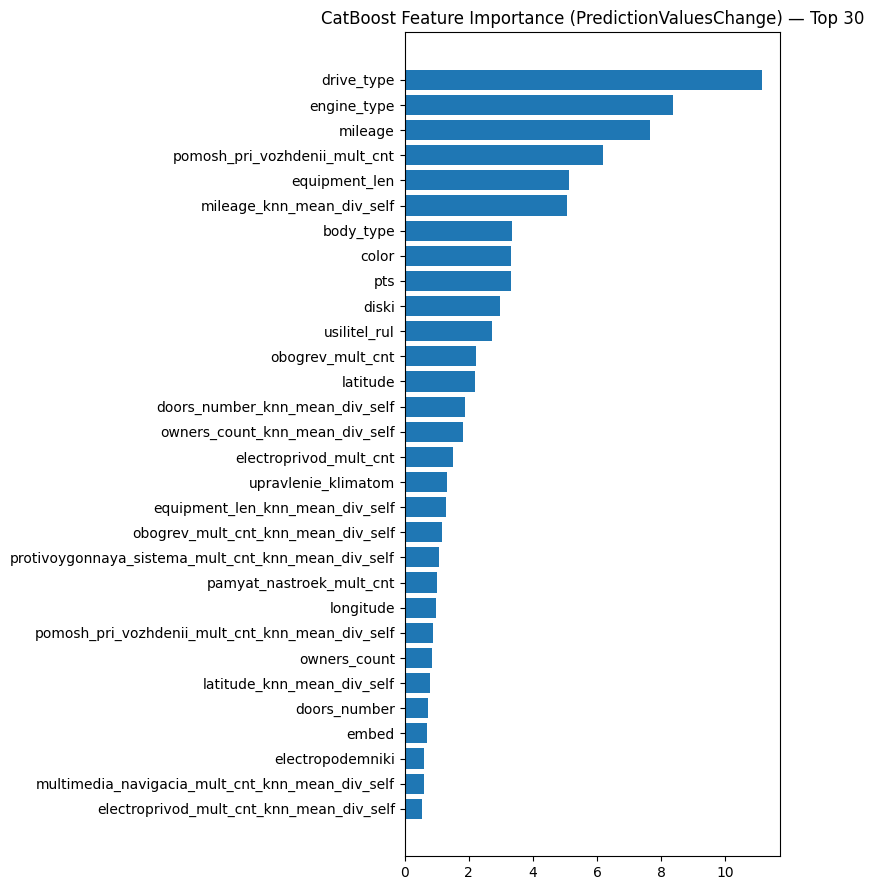

In [46]:
import numpy as np, pandas as pd
from catboost import Pool

# --- 0) страховка от NaN в числах ---
for df_ in (X_train_full, X_eval_full):
    num_cols_ = X_train_full.select_dtypes(include=[np.number]).columns
    df_[num_cols_] = df_[num_cols_].replace([np.inf, -np.inf], np.nan)
    for c in num_cols_:
        if df_[c].isna().any():
            df_[c] = df_[c].fillna(df_[c].median())

# embed точно не категориальная
cat_cols_full = [c for c in X_train_full.columns if str(X_train_full[c].dtype) == 'object' and c != 'embed']

# --- 1) Feature importance (PVC + LFC) ---
feature_names = list(X_train_full.columns)
train_pool = Pool(
    X_train_full, label=y_train,
    cat_features=cat_cols_full,
    embedding_features=['embed']
)

imp_pvc = model_final.get_feature_importance(train_pool, type='PredictionValuesChange')
fi = pd.DataFrame({'feature': feature_names, 'importance_pvc': imp_pvc})

# LFC может считаться заметно дольше; можно пропустить если нужно быстро
imp_lfc = model_final.get_feature_importance(train_pool, type='LossFunctionChange')
fi['importance_lfc'] = imp_lfc

fi_sorted = fi.sort_values('importance_pvc', ascending=False)
display(fi_sorted.head(30))

# аккуратный барчарт топ-30 (matplotlib)
import matplotlib.pyplot as plt
topk = 30
fig = plt.figure(figsize=(8, max(6, topk*0.3)))
sub = fi_sorted.head(topk).iloc[::-1]
plt.barh(sub['feature'], sub['importance_pvc'])
plt.title('CatBoost Feature Importance (PredictionValuesChange) — Top 30')
plt.tight_layout()
plt.show()


# Submissions

## Submission of catboost only table

In [47]:
from pandas.api.types import is_numeric_dtype

def align_test_columns(X_test: pd.DataFrame, X_train: pd.DataFrame, cat_cols: list):
    X_test = X_test.copy()

    # добавим недостающие колонки
    for c in X_train.columns:
        if c not in X_test.columns:
            if c in cat_cols:
                X_test[c] = "<NA>"
            else:
                X_test[c] = 0.0

    # выкинем лишние колонки
    extra = [c for c in X_test.columns if c not in X_train.columns]
    if extra:
        X_test.drop(columns=extra, inplace=True)

    # одинаковый порядок
    X_test = X_test[X_train.columns]

    # типы: категориальные -> object с заполнением, числовые -> медиана на NaN
    for c in cat_cols:
        if c in X_test.columns:
            X_test[c] = X_test[c].astype("string").fillna("<NA>").astype(object)

    for c in X_test.select_dtypes(include=[np.number]).columns:
        if X_test[c].isna().any() or np.isinf(X_test[c]).any():
            X_test[c] = X_test[c].replace([np.inf, -np.inf], np.nan).fillna(X_test[c].median())

    return X_test


In [48]:
# соберём X_test_tab под ту же схему, что X_train
X_test_tab = test.drop(columns=[ID_COL], errors="ignore")
# если целевая была в test_tab по ошибке — удалим:
X_test_tab = X_test_tab.drop(columns=[TARGET], errors="ignore")

# выровняем колонки и типы
X_test_tab = align_test_columns(X_test_tab, X_train, cat_cols_in_X)

# предсказания (клип от отрицательных цен)
pred_test_tab = catboost_model.predict(X_test_tab)
pred_test_tab = np.clip(pred_test_tab, 0, None)

sub_tab = sample.copy()
sub_tab["target"] = pred_test_tab
sub_tab.to_csv("submission_tabular.csv", index=False)
print("Saved submission_tabular.csv")
sub_tab.head()


Saved submission_tabular.csv


,ID,target
0,8,2.796951e+05
1,26,1.963526e+05
2,33,1.213271e+06
3,52,1.294213e+06
4,119,2.452196e+05


In [49]:
sub_tab.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 25000 entries, 0 to 24999
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   ID      25000 non-null  int64  
 1   target  25000 non-null  float64
dtypes: float64(1), int64(1)
memory usage: 390.8 KB


In [50]:
sample.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 25000 entries, 0 to 24999
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype
---  ------  --------------  -----
 0   ID      25000 non-null  int64
 1   target  25000 non-null  int64
dtypes: int64(2)
memory usage: 390.8 KB


In [51]:
# 2.1 база для соседей — объединяем train+eval
test_emb = extract_embeddings(model, test_dataloader)   # shape: (N_test, D)

# 0.2 cnn-предикты test (если ещё не в test_base)
# у тебя переменная называется test_preds (из infer_logits_and_preds), а не test_pred
if "cnn_pred" not in test.columns:
    test["cnn_pred"] = test_preds.astype("float32")

# инициализируем базовую табличку из уже фичезированного test
test_base = test.copy()

# sanity
assert len(test_base) == test_emb.shape[0], "test_base и test_emb разной длины"
assert len(test_base) == len(test_preds),   "test_base и test_preds разной длины"

# 0.3 база для kNN (train+eval)
X_all_base  = pd.concat([X_train, X_eval], axis=0)
all_emb     = np.vstack([train_emb, eval_emb])   # используем нашу устойчивую функцию

# 2.3 kNN-геометрия для теста (только eval-часть на базе)
_, test_knn_idx = build_knn_indices(all_emb, test_emb, k=32)

# 2.3 kNN-геометрия для теста (на общей базе)
def knn_geom_features_eval_on_base(base_emb, eval_emb, k=32):
    base_emb = l2norm(base_emb)
    eval_emb = l2norm(eval_emb)
    k_use = min(k, base_emb.shape[0])
    nn = NearestNeighbors(n_neighbors=k_use, metric='cosine').fit(base_emb)
    d_ev, idx_ev = nn.kneighbors(eval_emb, return_distance=True)
    sims_ev = 1.0 - d_ev
    ratio15 = sims_ev[:, 0] / (sims_ev[:, 4] + 1e-6) if sims_ev.shape[1] >= 5 else sims_ev[:, 0]
    feat_ev = np.column_stack([
        sims_ev[:, 0],
        sims_ev.mean(1),
        sims_ev.std(1),
        sims_ev[:, -1],
        ratio15
    ])
    cols = ['knn_maxsim','knn_meansim','knn_stdsim','knn_kthsim','knn_ratio1_5']
    return feat_ev, idx_ev, cols

test_geom, test_knn_idx2, geom_cols = knn_geom_features_eval_on_base(all_emb, test_emb, k=32)
# индексы должны совпадать по форме/значению
assert test_knn_idx.shape == test_knn_idx2.shape

df_test_geom = pd.DataFrame(test_geom, columns=geom_cols, index=test_base.index)

# 2.4 kNN-агрегации табличных фич для теста (соседи теста ищем в X_all_base)
from pandas.api.types import is_numeric_dtype
num_cols_all = [c for c in X_all_base.columns if is_numeric_dtype(X_all_base[c])]
cat_cols_all = [c for c in X_all_base.columns if not is_numeric_dtype(X_all_base[c])]

_, df_test_knn_tab = agg_tabular_over_knn(
    X_all_base, test_base,
    train_knn_idx=np.zeros((X_all_base.shape[0], 1), dtype=int),
    test_knn_idx=test_knn_idx,
    num_cols=num_cols_all,
    cat_cols=cat_cols_all
)


# 2.5 собираем X_test_full
X_test_full = pd.concat(
    [test_base.drop(columns=[ID_COL], errors="ignore"), df_test_geom, df_test_knn_tab],
    axis=1
)

# 2.6 embed-колонка: списки float32 фиксированной длины
emb_dim = test_emb.shape[1]
X_test_full["embed"] = [np.asarray(v, dtype="float32").tolist() for v in test_emb]

# 2.7 выравниваем под X_train_full и чистим NaN/Inf
from pandas.api.types import is_numeric_dtype
cat_cols_full = [c for c in X_train_full.columns if not is_numeric_dtype(X_train_full[c])]
if "embed" in cat_cols_full:
    cat_cols_full.remove("embed")

X_test_full = align_test_columns(X_test_full, X_train_full, cat_cols_full)

# на всякий случай добьём числовые NaN/Inf
num_cols_test = X_test_full.select_dtypes(include=[np.number]).columns
X_test_full[num_cols_test] = X_test_full[num_cols_test].replace([np.inf, -np.inf], np.nan)
for c in num_cols_test:
    if X_test_full[c].isna().any():
        X_test_full[c] = X_test_full[c].fillna(X_test_full[c].median())

# 2.8 предсказания
test_pool = Pool(X_test_full, cat_features=cat_cols_full, embedding_features=['embed'])
pred_test_full = model_final.predict(test_pool)
pred_test_full = np.clip(pred_test_full, 0, None)

sub_full = sample.copy()
sub_full["target"] = pred_test_full
sub_full.to_csv("submission_full.csv", index=False)
print("Saved submission_full.csv")

Saved submission_full.csv


## Submission of catboost over all features  

## If Vision model is good for this then: (TTA)

## IF Text and image is present then CLIP 🤗